In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
import pymc3 as pm

red = '#FF3300'
blue = '#0099CC'
green = '#00CC66'

sns.set(font_scale=2, style='whitegrid', palette='Set2')

# Смеси распределений в PyMC

Рассмотрим смесь двух пуассоновских распределений

$\mathsf{P} = 0.35\;Pois(1) + 0.65\;Pois(7)$

Сгенерируем выборку

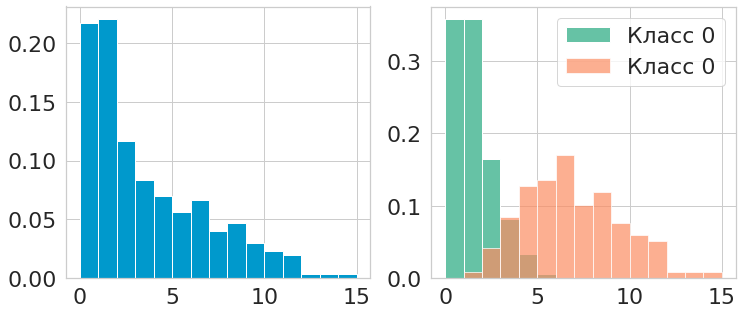

In [2]:
size = 300
y = sps.bernoulli(p=0.35).rvs(size=size)
x = sps.poisson(mu=1 + 6*y).rvs(size=size)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(x, density=True, range=(0, 15), bins=15, color=blue)
plt.subplot(122)
plt.hist(x[y==0], density=True, range=(0, 15), bins=15, label='Класс 0')
plt.hist(x[y==1], density=True, range=(0, 15), bins=15, label='Класс 0', alpha=0.7)
plt.legend();
sns.set(font_scale=2)

Задаем модель.

Распределение данных:

$\mathsf{P} = \pi_1\;Pois(\theta_1) + \pi_2\;Pois(\theta_2)$

Априорные распределения:

$\theta_1 \sim Exp(1)$

$\theta_2 \sim Exp(1)$

$\pi \sim Dirichlet(1, 1)$ (в даном случае это равномерное на симплексе $\pi_1 + \pi_2 = 1$)

In [4]:
with pm.Model() as model:
    # априорное распределение параметров компонент
    theta_1 = pm.Exponential('theta_1', lam=1)
    theta_2 = pm.Exponential('theta_2', lam=1)

    # априорное распределение вероятностей компонент
    pi = pm.Dirichlet('pi', a=np.array([1, 1]))

    # распределения компонент
    pois1 = pm.Poisson.dist(mu=theta_1)
    pois2 = pm.Poisson.dist(mu=theta_2)
    
    # сама смесь
    mix = pm.Mixture('mix', w=pi, comp_dists = [pois1, pois2], observed=x)

    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pi, theta_2, theta_1]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:04<00:00, 1194.93draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Посмотрим на случайные величины модели и на ее граф

In [5]:
model.basic_RVs

[theta_1_log__, theta_2_log__, pi_stickbreaking__, mix]

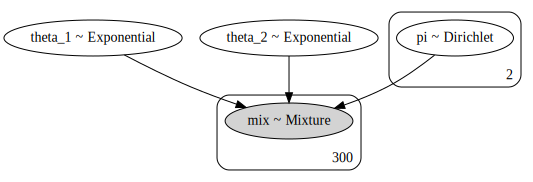

In [6]:
pm.model_to_graphviz(model)

Из-за того, что апостериорное распределение многомодально, на графике траекторий можно видеть подобные эффекты. В общем-то это не удивительно -- от перенумерации классов принципиально модель не поменяется. Казалось бы, что ничего плохого, но результаты двух цепей сливаются в одну траекторию, а это плохо. На графике для вероятностей показаны трактории вектора для каждой цепи.

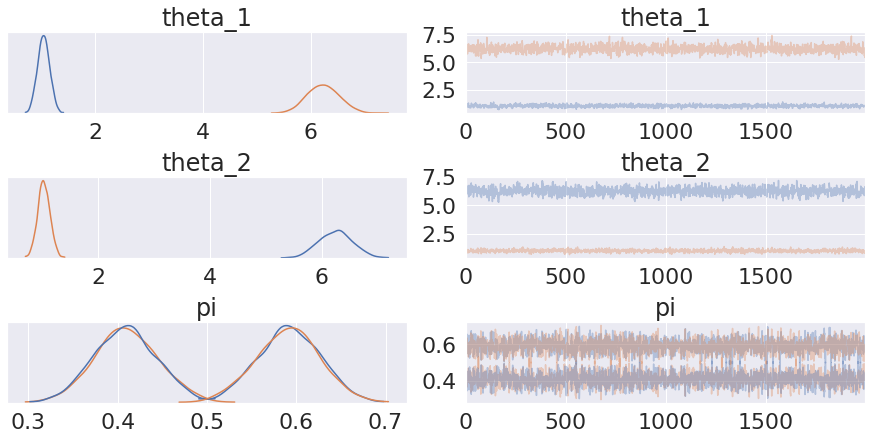

In [7]:
pm.traceplot(trace);

Действительно, результаты для разных классов перемешались. Это пример, когда методы MCMC отработали плохо

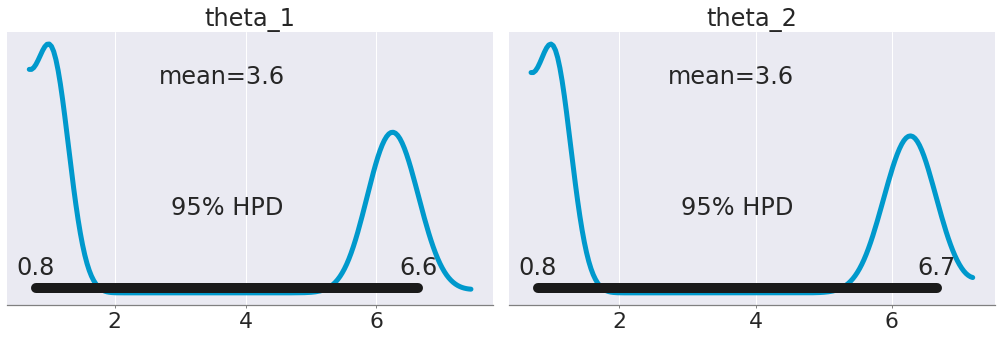

In [8]:
pm.plot_posterior(
    trace, 
    var_names=['theta_1','theta_2'],
    credible_interval=0.95,
    linewidth=5,
    color=blue
);

Попробуем другие данные

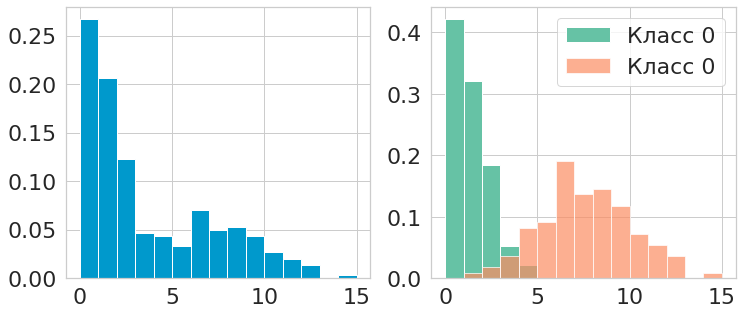

In [2]:
size = 300
y = sps.bernoulli(p=0.35).rvs(size=size)
x = sps.poisson(mu=1 + 6*y).rvs(size=size)

sns.set(font_scale=2, style='whitegrid', palette='Set2')
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(x, density=True, range=(0, 15), bins=15, color=blue)
plt.subplot(122)
plt.hist(x[y==0], density=True, range=(0, 15), bins=15, label='Класс 0')
plt.hist(x[y==1], density=True, range=(0, 15), bins=15, label='Класс 0', alpha=0.7)
plt.legend();
sns.set(font_scale=2)

Построим модель

In [13]:
with pm.Model() as model:
    # априорное распределение параметров компонент
    theta_1 = pm.Exponential('theta_1', lam=1)
    theta_2 = pm.Exponential('theta_2', lam=1)

    # априорное распределение вероятностей компонент
    pi = pm.Dirichlet('pi', a=np.array([1, 1]))

    # распределения компонент
    pois1 = pm.Poisson.dist(mu=theta_1)
    pois2 = pm.Poisson.dist(mu=theta_2)
    
    # сама смесь
    mix = pm.Mixture('mix', w=pi, comp_dists = [pois1, pois2], observed=x)

    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pi, theta_2, theta_1]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:04<00:00, 1181.15draws/s]


Здесь уже ничего не перепуталось

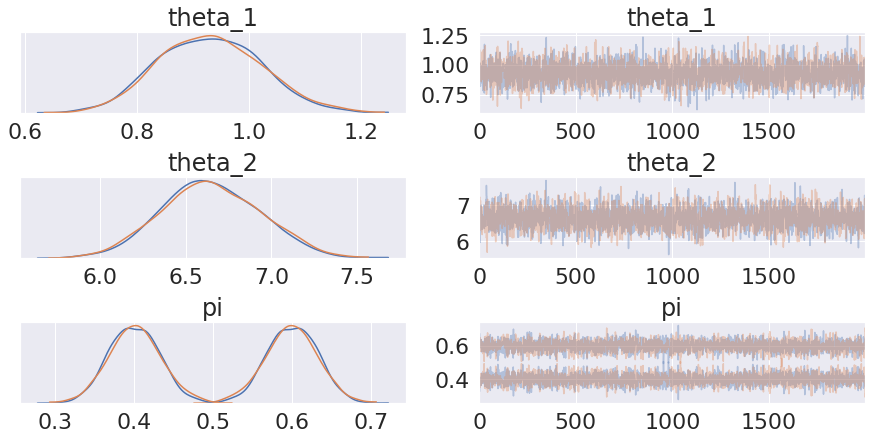

In [14]:
pm.traceplot(trace);

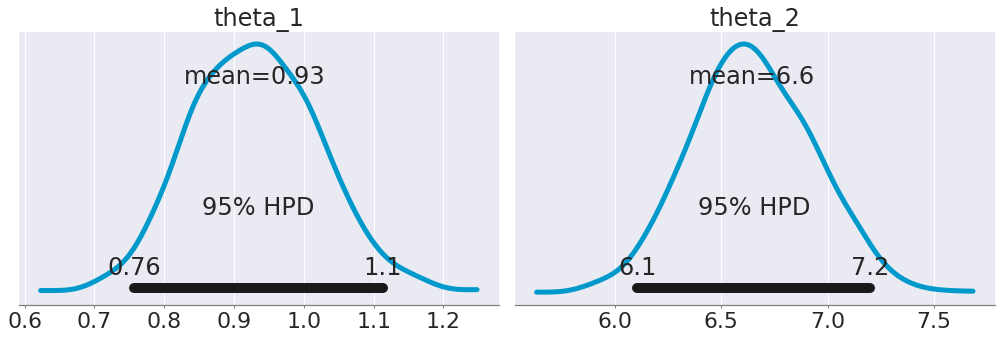

In [15]:
pm.plot_posterior(
    trace, 
    var_names=['theta_1','theta_2'],
    credible_interval=0.95,
    linewidth=5,
    color=blue
);